# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('/home/junpenglao/Documents/pymc3/docs/source/data/radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [2]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [3]:
%%time
init_num_chains = 50
model = hierarchical_model(data, county_idx)
pm4_trace, _ = pm.inference.sampling.sample(
    model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=False)

W0907 01:33:16.523927 140190453622592 deprecation.py:323] From /home/junpenglao/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1404: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 29.8 s, sys: 1.19 s, total: 31 s
Wall time: 23.2 s


### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [4]:
%%time
for i in range(3):
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
        step_size=step_size_, xla=False)

CPU times: user 1min 56s, sys: 6.55 s, total: 2min 3s
Wall time: 1min 10s


In [5]:
%%time
num_chains = 5
step_size_ = []
for _, x in pm4_trace.items():
    std = tf.math.reduce_std(x, axis=[0, 1])
    step_size_.append(
        std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

pm4_trace, sample_stat = pm.inference.sampling.sample(
    model, num_chains=num_chains, num_samples=500, burn_in=500,
    step_size=step_size_, xla=False)

CPU times: user 1min 34s, sys: 7.85 s, total: 1min 41s
Wall time: 49.7 s


In [6]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)

In [7]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.773021, 0.8168  , 0.851446, 0.797076, 0.714788], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

/home/junpenglao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/junpenglao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


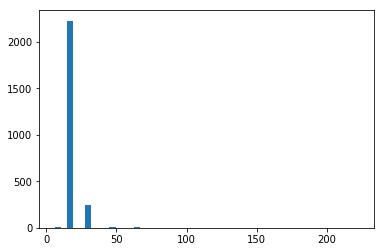

In [8]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [9]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/__log_sigma_beta,-1.295,0.422,-2.123,-0.606,0.052,0.038,67.0,63.0,76.0,118.0,1.04
hierarchical_model/__log_sigma_alpha,-1.143,0.137,-1.396,-0.880,0.005,0.004,739.0,728.0,737.0,1394.0,1.00
hierarchical_model/beta[0],-0.602,0.291,-1.155,-0.052,0.006,0.005,2029.0,2029.0,2077.0,1708.0,1.01
hierarchical_model/beta[1],-0.799,0.256,-1.278,-0.302,0.007,0.006,1285.0,1042.0,1326.0,1393.0,1.01
hierarchical_model/beta[2],-0.633,0.278,-1.142,-0.102,0.005,0.004,2570.0,2301.0,2511.0,1526.0,1.00
hierarchical_model/beta[3],-0.672,0.248,-1.158,-0.207,0.006,0.004,1971.0,1971.0,1956.0,1108.0,1.00
hierarchical_model/beta[4],-0.585,0.298,-1.125,0.016,0.008,0.005,1546.0,1546.0,1886.0,1047.0,1.00
hierarchical_model/beta[5],-0.629,0.342,-1.264,0.061,0.007,0.006,2212.0,1568.0,2215.0,1230.0,1.01
hierarchical_model/beta[6],-0.377,0.310,-0.912,0.233,0.018,0.013,302.0,302.0,314.0,1014.0,1.01
hierarchical_model/beta[7],-0.602,0.285,-1.151,-0.051,0.007,0.005,1886.0,1886.0,1956.0,1281.0,1.00


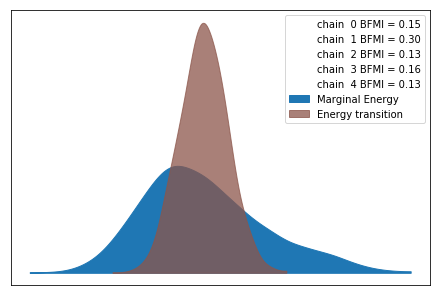

In [10]:
az.plot_energy(az_trace);

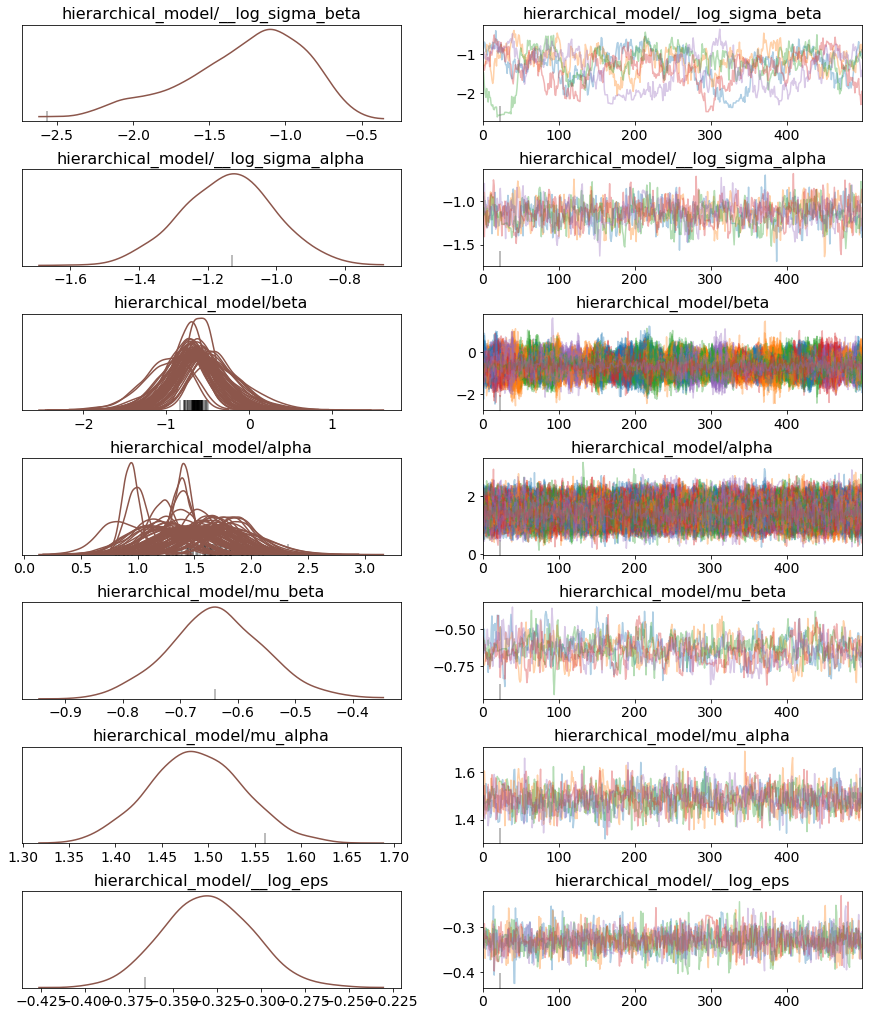

In [11]:
az.plot_trace(az_trace, compact=True, combined=True);